In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 4)), labels=classes)
    plt.yticks(list(range(0, 4)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


In [2]:
ISEAR_dataset = pd.read_csv('G:\My Drive\AnjanaValsalan_ECNG 3020\Implementation Files\Datasets\ISEAR csv\ISEAR.csv')
ISEAR_dataset.dropna(axis=1, how="any", thresh=None, subset=None, inplace=True)
ISEAR_dataset = ISEAR_dataset[ISEAR_dataset.emotion != 'disgust']
ISEAR_dataset = ISEAR_dataset[ISEAR_dataset.emotion != 'shame']
ISEAR_dataset = ISEAR_dataset[ISEAR_dataset.emotion != 'guilt']
ISEAR_dataset = ISEAR_dataset[["sentence", "emotion"]]
ISEAR_dataset = ISEAR_dataset.rename(columns={'sentence':'text','emotion':'label'})
ISEAR_dataset.groupby(['label']).count()

,text
label,
anger,1079
fear,1076
joy,1092
sadness,1082


In [87]:
for index, row in ISEAR_dataset.iterrows():
    row["text"] = row["text"].strip().replace("   "," ").replace("  "," ")

In [88]:
ISEAR_train = ISEAR_dataset[0: int(0.8*len(ISEAR_dataset))]
ISEAR_val = ISEAR_dataset[int(0.8*len(ISEAR_dataset)):int(0.9*len(ISEAR_dataset))]
ISEAR_test = ISEAR_dataset[int(0.9*len(ISEAR_dataset)):]

In [89]:
print(ISEAR_train)

                                                   text    label
0     On days when I feel close to my partner and ot...      joy
1     Every time I imagine that someone I love or I ...     fear
2     When I had been obviously unjustly treated and...    anger
3     When I think about the short time that we live...  sadness
7     After my girlfriend had taken her exam we went...      joy
...                                                 ...      ...
6001  I felt angry when repeated pleas to the ticket...    anger
6002  I am filled with gloom and sadness at the deat...  sadness
6006  When India first won the world cup cricket tou...      joy
6007  I was then in the 10th standard and was going ...     fear
6008  I was travelling from Delhi to Bombay. I had b...    anger

[3463 rows x 2 columns]


In [90]:
from datasets import load_dataset
dataset = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (C:\Users\valsa\.cache\huggingface\datasets\emotion\default\0.0.0\348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [91]:
dataset.set_format(type="pandas")
train = dataset["train"][:]
test = dataset["test"][:]
val = dataset["validation"][:]

In [92]:
train = train[train.label != 2]
train = train[train.label != 5]
frames = [ISEAR_train, train]
train = pd.concat(frames)
train = train.reset_index(drop=True)

test = test[test.label != 2]
test = test[test.label != 5]
frames = [ISEAR_test, test]
test = pd.concat(frames)
test = test.reset_index(drop=True)

val = val[val.label != 2]
val = val[val.label != 5]
frames = [ISEAR_val, val]
val = pd.concat(frames)
val = val.reset_index(drop=True)

In [93]:
def get_tweet(data):
    tweets = data['text']
    labels = data['label']
    labels = labels.replace([0,1,3,4],['sadness','joy','anger','fear'])
    return tweets, labels

In [94]:
tweets, labels = get_tweet(train)

In [95]:
print(train)

                                                    text    label
0      On days when I feel close to my partner and ot...      joy
1      Every time I imagine that someone I love or I ...     fear
2      When I had been obviously unjustly treated and...    anger
3      When I think about the short time that we live...  sadness
4      After my girlfriend had taken her exam we went...      joy
...                                                  ...      ...
17582  i just had a very brief time in the beanbag an...        0
17583  i am now turning and i feel pathetic that i am...        0
17584                     i feel strong and good overall        1
17585  i feel like this was such a rude comment and i...        3
17586  i know a lot but i feel so stupid because i ca...        0

[17587 rows x 2 columns]


In [96]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [97]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [98]:
tokenizer.texts_to_sequences([tweets[1]])

[[173, 46, 2, 969, 10, 136, 2, 103, 38, 2, 82, 1149, 7, 1203, 1046, 80, 328]]

In [99]:
tweets[1]

'Every time I imagine that someone I love or I could contact a serious illness, even death.'

<function matplotlib.pyplot.show(close=None, block=None)>

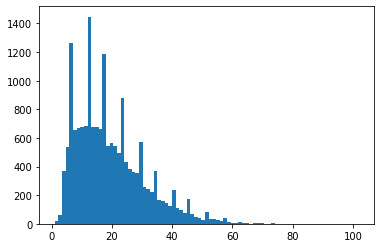

In [100]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show

In [101]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [102]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post' , padding='post', maxlen = maxlen)
  return padded

In [103]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [104]:
padded_train_seq

array([[ 29, 155,  16, ...,   0,   0,   0],
       [173,  46,   2, ...,   0,   0,   0],
       [ 16,   2,  30, ...,   0,   0,   0],
       ...,
       [  2,   5, 359, ...,   0,   0,   0],
       [  2,   5,  18, ...,   0,   0,   0],
       [  2,  52,   7, ...,   0,   0,   0]])

In [105]:
classes = set(labels)
print(classes)

{'anger', 'fear', 'joy', 'sadness'}


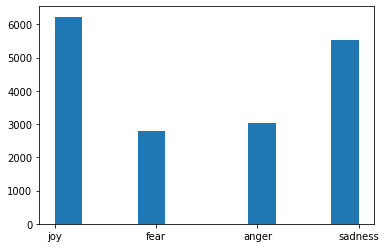

In [106]:
plt.hist(labels, bins=11)
plt.show()

In [107]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [108]:
class_to_index

{'anger': 0, 'fear': 1, 'joy': 2, 'sadness': 3}

In [109]:
index_to_class

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness'}

In [110]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [111]:
train_labels = names_to_ids(labels)
print(train_labels[0])

2


In [112]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [113]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            160000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [114]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [115]:
val_tweets[0], val_labels[0]

('The news of the natural calamity, an earthquake in which hundreds of Mexican people died.',
 3)

In [116]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
550/550 [==============================] - 15s 16ms/step - loss: 1.1581 - accuracy: 0.4721 - val_loss: 0.6746 - val_accuracy: 0.7042
Epoch 2/20
550/550 [==============================] - 7s 13ms/step - loss: 0.5030 - accuracy: 0.7895 - val_loss: 0.5356 - val_accuracy: 0.7948
Epoch 3/20
550/550 [==============================] - 7s 13ms/step - loss: 0.3070 - accuracy: 0.8936 - val_loss: 0.4357 - val_accuracy: 0.8615
Epoch 4/20
550/550 [==============================] - 7s 13ms/step - loss: 0.2028 - accuracy: 0.9356 - val_loss: 0.4454 - val_accuracy: 0.8666
Epoch 5/20
550/550 [==============================] - 7s 13ms/step - loss: 0.1559 - accuracy: 0.9531 - val_loss: 0.4252 - val_accuracy: 0.8717
Epoch 6/20
550/550 [==============================] - 7s 13ms/step - loss: 0.1223 - accuracy: 0.9641 - val_loss: 0.4323 - val_accuracy: 0.8804
Epoch 7/20
550/550 [==============================] - 7s 13ms/step - loss: 0.0932 - accuracy: 0.9734 - val_loss: 0.4786 - val_accuracy: 0.876

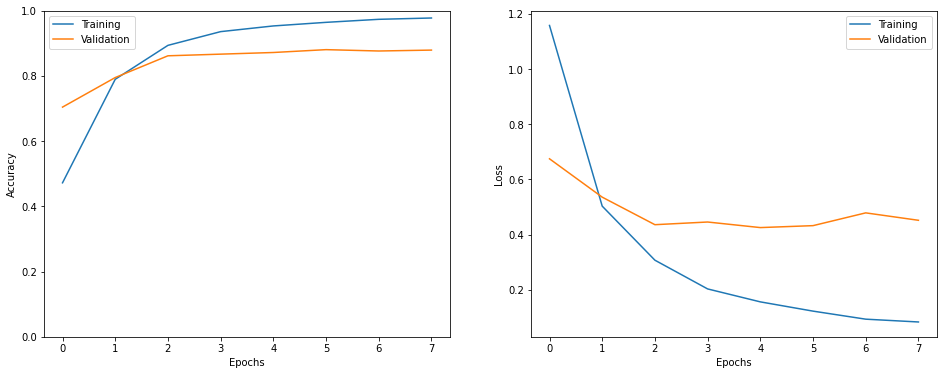

In [117]:
show_history(h)

In [118]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [119]:
_=model.evaluate(test_seq, test_labels)

69/69 [==============================] - 2s 11ms/step - loss: 0.5185 - accuracy: 0.8673


In [120]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i feel like uninstalling skype deactivateing all of my facebook amp hatena accounts since im becoming a hateful person amp i dont want to get any worse than i am right now
Emotion: anger
Predicted Emotion: anger


In [121]:
preds = np.argmax(model.predict(test_seq), axis=-1)

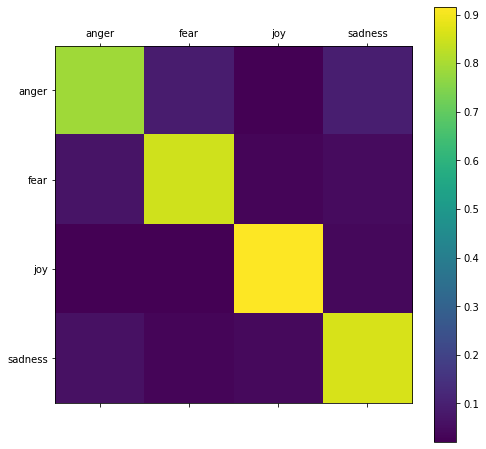

In [122]:
show_confusion_matrix(test_labels, preds, list(classes))